# Simultaneous Fitting of a Transit with Stellar Variability

In [1]:
import lightkurve as lk
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as plt
import pandas as pd

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import starry
import pdb
from astropy import constants as const
from astropy import units as u

%matplotlib inline

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


(3360.0, 3366.0)

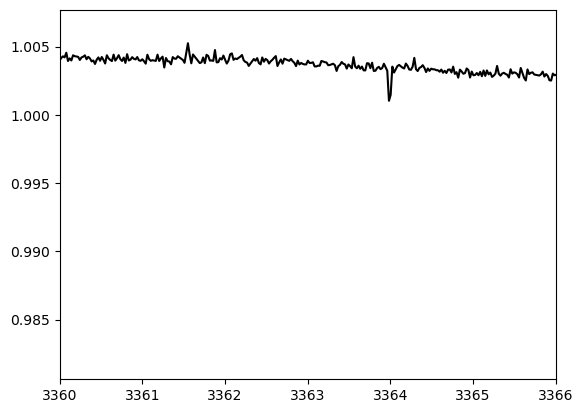

In [51]:
df = pd.read_csv('k2camp2.dat',sep='\t',names='time flux fluxerr inst'.split())



time = (df['time'] - 2454833).values
flux = df['flux'].values
flux_error = df['fluxerr'].values

plt.plot(time, flux, 'k')
plt.xlim(3360, 3366)

In [4]:
np.mean(flux_error)**2

6.749587049549708e-08

{'index': 1273, 'log_power': -17.374857289039028, 'period': 1.9120518254421133, 'period_uncert': 0.026776783617700427}


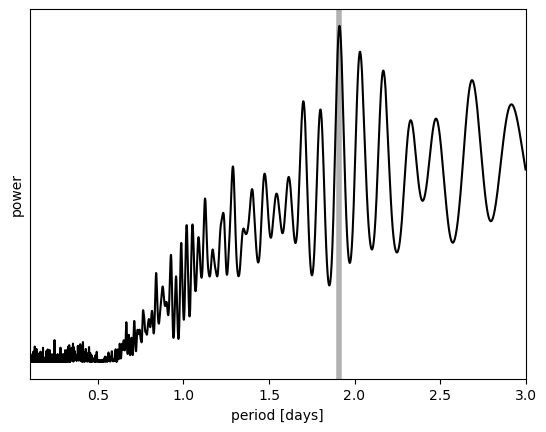

In [18]:
results = xo.estimators.lomb_scargle_estimator(
    time, flux, max_peaks = 1, min_period = 0.1, max_period = 3, samples_per_peak = 100
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")
print(peak)


# First Fitting #

In [46]:
periods = [6.7252337648, 1000]
period_error = [0.1, 500]
t0s = [2457221.8349184883 - 2454833, 2458213.8222186137 - 2454833] #[2388.835, 3380.822]
t0_error = [0.1, 0.1]
duration = [0.9/24, 15.71/24]
nplanets = 2
R_star = [0.79,0.02] #in solar radii
M_star = [0.82,0.03] #in solar mass
Expected_msini = [1,1] #in earth units #caleb check
Teff = [4870, 88] #in Kelvin and uncertainty is +/- 88
ecc_fit = True

Rsun2Rearth = (const.R_sun/const.R_earth).value
RsunPerDay = ((const.R_sun/u.d).to(u.m/u.s)).value
Rsun2AU = (const.R_sun).to(u.au).value

#pdb.set_trace()

with pm.Model() as model:

    mean = pm.Normal("mean", mu=0.0, sigma = 1.0, testval = 1) #the mean of the lightcurve (approx 1)
    ustar = xo.distributions.QuadLimbDark("u")
    
    # Stellar parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1.5)
    m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
    r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])
    teff = pm.Bound(pm.Normal, lower=2000, upper=7000)("teff", mu=Teff[0], sd=Teff[1])
    st_lum = pm.Deterministic("st_lum", (r_star**2) * ((teff/5777)**4)) #stellar luminosity #derived parameter
    star_params = [mean, ustar] 
    
    # Planet parameters
    ror = pm.Uniform("ror", lower=0.01, upper = 0.99, shape=nplanets) #, testval=np.array([0.04, 0.06]))
    r_pl = pm.Deterministic("r_pl", ror*r_star) #in physical units aka stellar radii #not a free parameter but you can calculate at every step
#     m_pl = pm.Uniform("m_pl", lower=0.1, upper=3e4, testval=Expected_msini, shape=nplanets)
#     # deterministic means values that were derived from the model
#     density_pl = pm.Deterministic("density_pl", m_pl/((r_pl*Rsun2Rearth)**3) * 5.514) # Convert from rho_earth to g/cm3

    # Orbital parameters
    period = pm.Normal("period", mu = np.array(periods), sigma= np.array(period_error), shape=nplanets)
    t0 = pm.Normal("t0", mu=t0s, sigma=np.array(t0_error), shape=nplanets)
    b = pm.Uniform("b", lower = 0, upper = 1, shape=nplanets)
    
    # Set up the orbit
    #orbit = xo.orbits.KeplerianOrbit(period=period, ror = ror, duration=dur, t0=t0, b=b)

    if ecc_fit:
        # for an eccentric orbit # 
        ecs = pmx.UnitDisk("ecs", testval=np.array([[0.1, 0.1]] * nplanets).T, shape=(2, nplanets))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    else:
        # for circular orbit #
        ecc = np.repeat(0, nplanets)
        omega = np.repeat(np.pi/2, nplanets)

    # Orbit model
    orbit = xo.orbits.KeplerianOrbit(r_star = r_star, m_star= m_star, 
                                     period = period, t0 = t0, b = b, 
                                     ecc = ecc, omega = omega) #, m_planet = xo.units.with_unit(m_pl, u.M_earth))
    pm.Deterministic("rho_circ", orbit.rho_star)
    pm.Deterministic("aor", orbit.a / r_star)
    
    # Set up the mean transit model
    star = xo.LimbDarkLightCurve(ustar)
    
    ### Calculates lc for each planet at its time vector ###
    light_curves = star.get_light_curve(orbit=orbit, r=r_pl, t=time, 
                                        texp = 29.4*u.min.to('d'))
    
    ### Saves the individual lightcurves ###
    pm.Deterministic("light_curves", light_curves) 
    
    ### Full photometric model, the sum of all transits + the baseline (mean) ###
    lc_model = mean + tt.sum(light_curves, axis=-1)
    
#     # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=lc_model, sd=flux_error, observed=flux)

    
##################################################### GP MODEL ##################################################
##################################################### GP MODEL ##################################################
    

    # A jitter term describing excess white noise
    jitter = pm.Normal("jitter", mu = np.mean(flux_error), sigma = 3.0)
    
#     # The Parameters of the SHO Kernel 
#     sigma = pm.InverseGamma(
#         "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0) 
#     )
#     rho = pm.InverseGamma(
#         "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.5)
#     )
    # The Parameters of the RotationTerm Kernel 
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    prot = pm.Normal("prot", mu = 1.9120518254421133, sigma = 0.026776783617700427) # 6.057719351364237, 0.21315980404897117 #0.2133955928082091
    Q0 = pm.Normal("Q0", mu = 6, sigma = 1) ##try changing this first (very small or very large numbs)
    dQ = pm.Normal("dQ", mu = 3, sigma = 1) ##try changing this first (very small or very large numbs)
    f = pm.Uniform("f", lower = 0.1, upper = 1.0)
    
    # The SHO Kernel
#     kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q = 1 / 3.0)
    
    # The Rotation Kernel
    kernel = terms.RotationTerm(
        sigma = sigma_rot,
        period = prot,
        Q0 = Q0,
        dQ = dQ,
        f = f,
    )
    
    gp = GaussianProcess(
        kernel,
        t = time,
        diag = flux_error**2 + tt.exp(2 * jitter), #changed 
        mean = mean,
        quiet = True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    
    gp.marginal("no_transit_lc", observed = flux - lc_model)

    # Compute the GP model prediction for plotting purposes
    pm.Deterministic("gp_pred", gp.predict(flux - lc_model))
    
    # Optimize the MAP solution.
    map_soln = model.test_point
    print(model.check_test_point())
    
    ### Optimizing LC model ###
    map_soln = pmx.optimize(
        vars=[
            ror,
            b,
            t0,
            period,
            r_star,
            ustar,
            mean,
        ],
    )
    if ecc_fit:
        map_soln = pmx.optimize(map_soln, vars = ecs)

        
### Optimizing GP model ###### Optimizing GP model ###### Optimizing GP model ###### Optimizing GP model ###

    # SHO Kernel
#     map_soln = pmx.optimize(vars=[sigma, rho]) # find the best values for my SHO #
    
    # Rotational Kernel
    map_soln = pmx.optimize(vars=[sigma_rot, f, prot, Q0, dQ])
        
        
    map_soln = pmx.optimize(map_soln)


mean                             -1.42
u_quadlimbdark__                 -2.77
m_star_interval__                -1.12
r_star_interval__                 0.01
teff_interval__                  -7.10
ror_interval__                   -2.77
period                           -5.75
t0                                2.77
b_interval__                     -2.77
ecs_unitdisk+interval__          -2.82
jitter                           -2.02
sigma_rot_log__                   0.11
prot                              2.70
Q0                               -0.92
dQ                               -0.92
f_interval__                     -1.39
obs                       -25546447.71
no_transit_lc                 -3433.21
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [mean, u, r_star, period, t0, b, ror]


message: Desired error not necessarily achieved due to precision loss.
logp: -25549907.098338753 -> -91418.04466379127
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -91418.04466379127 -> -91418.02354578074
optimizing logp for variables: [dQ, Q0, prot, f, sigma_rot]


message: Optimization terminated successfully.
logp: -25549907.098338753 -> -25549516.62513286
optimizing logp for variables: [f, dQ, Q0, prot, sigma_rot, jitter, ecs, b, t0, period, ror, teff, r_star, m_star, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -25549516.62513286 -> -75892.85961626947


In [25]:
print('*** MAP Fit Parameters ***')
for thiskey in list(map_soln.keys())[:-1]:
    if bool(thiskey.find('__')+1):
        continue
    print('{}: {}'.format(thiskey, map_soln[thiskey]))
    

*** MAP Fit Parameters ***
mean: 1.0039360363301184
period: [  6.68899101 999.99648891]
t0: [2390.50222437 3381.58919719]
jitter: -0.3004876227307388
prot: 1.925078246193702
Q0: -3.498341922335622
dQ: -2.3007218564786958
u: [0.49644266 0.24743156]
m_star: 1.0332327847689582
r_star: 1.4999969078837339
teff: 4507.156730665886
st_lum: 0.8336464381171785
ror: [0.01978179 0.01694106]
r_pl: [0.02967263 0.02541154]
b: [0.34784926 0.99362783]
ecs: [[-0.78033613  0.26574946]
 [-0.47860504  0.51390355]]
ecc: [0.83798727 0.33471964]
omega: [-2.59142791  1.09354724]
rho_circ: 0.43159696058093855
aor: [ 10.06902056 283.62584517]
light_curves: [[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
sigma_rot: 0.594189152235576
f: 0.11568833225719827


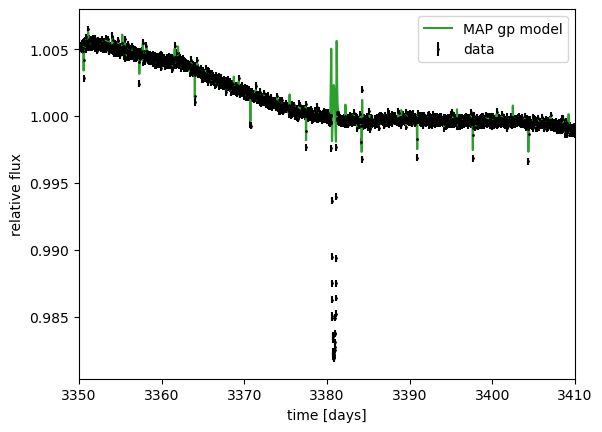

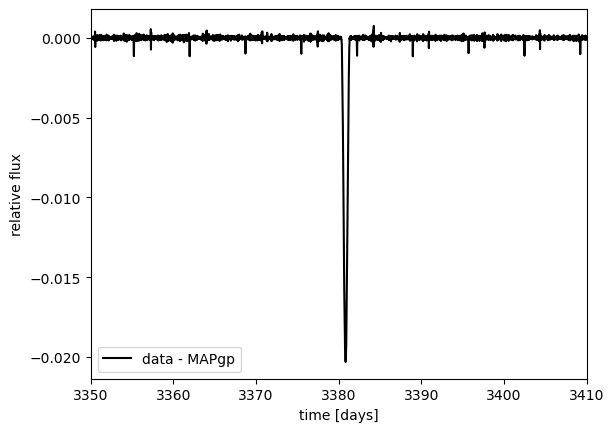

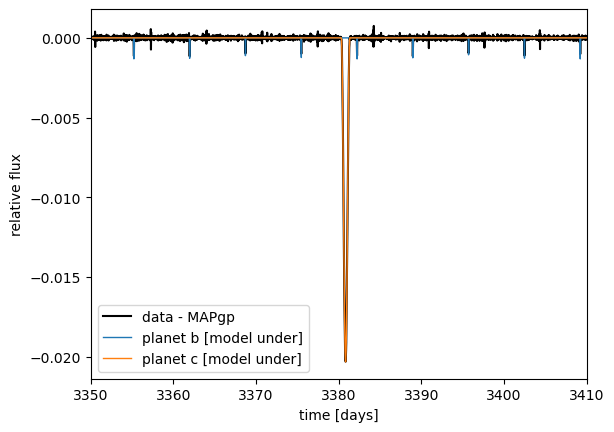

In [49]:
gp_mod = map_soln["gp_pred"] + map_soln["mean"]

plt.figure()
plt.errorbar(time, flux, yerr = flux_error, color = 'k', marker = ".", linestyle = 'none', ms=2, label="data")
plt.plot(time, gp_mod, color="C2", label="MAP gp model")
# for i, l in enumerate("bc"):
#     plt.plot(
#         time, map_soln["light_curves"][:,i]+map_soln["mean"], lw=1, label="planet {0}".format(l)
#     )
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(3350, 3410)
#plt.ylim(0.99, 1.16)
plt.legend(fontsize=10)

plt.figure()
plt.plot(time, flux - gp_mod, "k", label = "data - MAPgp")
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(3350, 3410)
plt.legend(fontsize=10)

plt.figure()
plt.plot(time, flux - gp_mod, "k", label="data - MAPgp")

for i, l in enumerate("bc"):
    mod = map_soln["light_curves"][:, i]
    plt.plot(time, mod, lw = 1, label="planet {0} [model under]".format(l))
    
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(3350, 3410)
# plt.xlim(3354, 3360)
plt.legend(fontsize=10)

# Second Fitting #

In [52]:
periods = [6.7252337648, 1000]
period_error = [0.1, 500]
t0s = [2457221.8349184883 - 2454833, 2458213.8222186137 - 2454833] #[2388.835, 3380.822]
t0_error = [0.1, 0.1]
duration = [0.9/24, 15.71/24]
nplanets = 2
R_star = [0.79,0.02] #in solar radii
M_star = [0.82,0.03] #in solar mass
Expected_msini = [1,1] #in earth units #caleb check
Teff = [4870, 88] #in Kelvin and uncertainty is +/- 88
ecc_fit = True

Rsun2Rearth = (const.R_sun/const.R_earth).value
RsunPerDay = ((const.R_sun/u.d).to(u.m/u.s)).value
Rsun2AU = (const.R_sun).to(u.au).value

#pdb.set_trace()

with pm.Model() as model:

    mean = pm.Normal("mean", mu=0.0, sigma = 1.0, testval = 1) #the mean of the lightcurve (approx 1)
    ustar = xo.distributions.QuadLimbDark("u")
    
    # Stellar parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1.5)
    m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
    r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])
    teff = pm.Bound(pm.Normal, lower=2000, upper=7000)("teff", mu=Teff[0], sd=Teff[1])
    st_lum = pm.Deterministic("st_lum", (r_star**2) * ((teff/5777)**4)) #stellar luminosity #derived parameter
    star_params = [mean, ustar] 
    
    # Planet parameters
    ror = pm.Uniform("ror", lower=0.01, upper = 0.99, shape=nplanets) #, testval=np.array([0.04, 0.06]))
    r_pl = pm.Deterministic("r_pl", ror*r_star) #in physical units aka stellar radii #not a free parameter but you can calculate at every step
#     m_pl = pm.Uniform("m_pl", lower=0.1, upper=3e4, testval=Expected_msini, shape=nplanets)
#     # deterministic means values that were derived from the model
#     density_pl = pm.Deterministic("density_pl", m_pl/((r_pl*Rsun2Rearth)**3) * 5.514) # Convert from rho_earth to g/cm3

    # Orbital parameters
    period = pm.Normal("period", mu = np.array(periods), sigma= np.array(period_error), shape=nplanets)
    t0 = pm.Normal("t0", mu=t0s, sigma=np.array(t0_error), shape=nplanets)
    b = pm.Uniform("b", lower = 0, upper = 1, shape=nplanets)
    
    # Set up the orbit
    #orbit = xo.orbits.KeplerianOrbit(period=period, ror = ror, duration=dur, t0=t0, b=b)

    if ecc_fit:
        # for an eccentric orbit # 
        ecs = pmx.UnitDisk("ecs", testval=np.array([[0.1, 0.1]] * nplanets).T, shape=(2, nplanets))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    else:
        # for circular orbit #
        ecc = np.repeat(0, nplanets)
        omega = np.repeat(np.pi/2, nplanets)

    # Orbit model
    orbit = xo.orbits.KeplerianOrbit(r_star = r_star, m_star= m_star, 
                                     period = period, t0 = t0, b = b, 
                                     ecc = ecc, omega = omega) #, m_planet = xo.units.with_unit(m_pl, u.M_earth))
    pm.Deterministic("rho_circ", orbit.rho_star)
    pm.Deterministic("aor", orbit.a / r_star)
    
    # Set up the mean transit model
    star = xo.LimbDarkLightCurve(ustar)
    
    ### Calculates lc for each planet at its time vector ###
    light_curves = star.get_light_curve(orbit=orbit, r=r_pl, t=time, 
                                        texp = 29.4*u.min.to('d'))
    
    ### Saves the individual lightcurves ###
    pm.Deterministic("light_curves", light_curves) 
    
    ### Full photometric model, the sum of all transits + the baseline (mean) ###
    lc_model = mean + tt.sum(light_curves, axis=-1)
    
#     # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=lc_model, sd=flux_error, observed=flux)

    
##################################################### GP MODEL ##################################################
##################################################### GP MODEL ##################################################
    

    # A jitter term describing excess white noise
    jitter = pm.Normal("jitter", mu = np.mean(flux_error), sigma = 2.0)
    
#     # The Parameters of the SHO Kernel 
#     sigma = pm.InverseGamma(
#         "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 6.0) 
#     )
#     rho = pm.InverseGamma(
#         "rho", **pmx.estimate_inverse_gamma_parameters(1, 7.0)
#     )
    # The Parameters of the RotationTerm Kernel 
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 8.0)
    )
    prot = pm.Normal("prot", mu = 1.9120518254421133, sigma = 0.026776783617700427) # 6.057719351364237, 0.21315980404897117 #0.2133955928082091
    Q0 = pm.Normal("Q0", mu = 10, sigma = 1) ##try changing this first (very small or very large numbs)
    dQ = pm.Normal("dQ", mu = 4.5, sigma = 1) ##try changing this first (very small or very large numbs)
    f = pm.Uniform("f", lower = 0.1, upper = 1.0)
    
    # The SHO Kernel
#     kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q = 1 / 3.0)
    
    # The Rotation Kernel
    kernel = terms.RotationTerm(
        sigma = sigma_rot,
        period = prot,
        Q0 = Q0,
        dQ = dQ,
        f = f,
    )
    
    gp = GaussianProcess(
        kernel,
        t = time,
        diag = flux_error**2 + tt.exp(2 * jitter), #changed 
        mean = mean,
        quiet = True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    
    gp.marginal("no_transit_lc", observed = flux - lc_model)

    # Compute the GP model prediction for plotting purposes
    pm.Deterministic("gp_pred", gp.predict(flux - lc_model))
    
    # Optimize the MAP solution.
    map_soln = model.test_point
    print(model.check_test_point())
    
    ### Optimizing LC model ###
    map_soln = pmx.optimize(
        vars=[
            ror,
            b,
            t0,
            period,
            r_star,
            ustar,
            mean,
        ],
    )
    if ecc_fit:
        map_soln = pmx.optimize(map_soln, vars = ecs)

        
### Optimizing GP model ###### Optimizing GP model ###### Optimizing GP model ###### Optimizing GP model ###

    # SHO Kernel
#     map_soln = pmx.optimize(vars=[sigma, rho]) # find the best values for my SHO #
    
    # Rotational Kernel
    map_soln = pmx.optimize(vars=[sigma_rot, f, prot, Q0, dQ])
        
        
    map_soln = pmx.optimize(map_soln)


mean                             -1.42
u_quadlimbdark__                 -2.77
m_star_interval__                -1.12
r_star_interval__                 0.01
teff_interval__                  -7.10
ror_interval__                   -2.77
period                           -5.75
t0                                2.77
b_interval__                     -2.77
ecs_unitdisk+interval__          -2.82
jitter                           -1.61
sigma_rot_log__                  -0.16
prot                              2.70
Q0                               -0.92
dQ                               -0.92
f_interval__                     -1.39
obs                       -25546447.71
no_transit_lc                 -3461.93
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [mean, u, r_star, period, t0, b, ror]


message: Desired error not necessarily achieved due to precision loss.
logp: -25549935.683147676 -> -91461.98199945794
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -91461.98199945794 -> -91461.45692607091
optimizing logp for variables: [dQ, Q0, prot, f, sigma_rot]


message: Desired error not necessarily achieved due to precision loss.
logp: -25549935.683147676 -> -25549567.240971465
optimizing logp for variables: [f, dQ, Q0, prot, sigma_rot, jitter, ecs, b, t0, period, ror, teff, r_star, m_star, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -25549567.240971465 -> -134354.29409954837


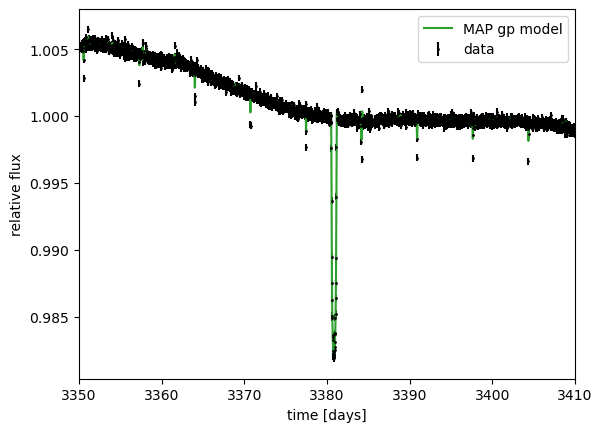

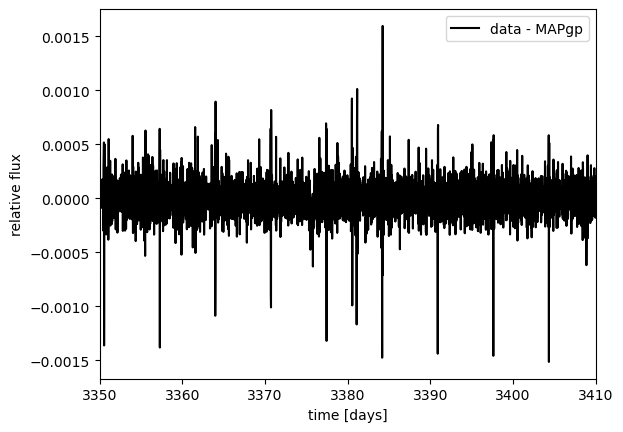

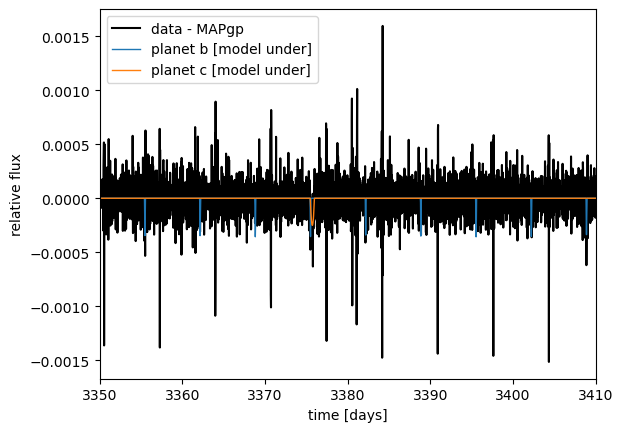

In [53]:
gp_mod = map_soln["gp_pred"] + map_soln["mean"]

plt.figure()
plt.errorbar(time, flux, yerr = flux_error, color = 'k', marker = ".", linestyle = 'none', ms=2, label="data")
plt.plot(time, gp_mod, color="C2", label="MAP gp model")
# for i, l in enumerate("bc"):
#     plt.plot(
#         time, map_soln["light_curves"][:,i]+map_soln["mean"], lw=1, label="planet {0}".format(l)
#     )
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(3350, 3410)
#plt.ylim(0.99, 1.16)
plt.legend(fontsize=10)

plt.figure()
plt.plot(time, flux - gp_mod, "k", label = "data - MAPgp")
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(3350, 3410)
plt.legend(fontsize=10)

plt.figure()
plt.plot(time, flux - gp_mod, "k", label="data - MAPgp")

for i, l in enumerate("bc"):
    mod = map_soln["light_curves"][:, i]
    plt.plot(time, mod, lw = 1, label="planet {0} [model under]".format(l))
    
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(3350, 3410)
# plt.xlim(3354, 3360)
plt.legend(fontsize=10)

In [15]:
# # Plot the folded transit
# fig, ax = plt.subplots(figsize=(10, 5))

# period = 6.7252337648

# t0 = 2457221.8349184883 - 2454833 #[2388.835, 3380.822]



# x_fold = (time - t0 + 0.5 * period) % period - 0.5 * period
# m = np.abs(x_fold) < 0.5
# ax.scatter(
#     x_fold[m],
#     1e3 * (flux[m] - map_soln["gp_pred"][m]),
#     c="k",
#     marker=".",
#     alpha=0.2,
#     linewidths=0,
# )

# lc_mod = lc_model[:, 0]
# lc_modx = np.sort(x_fold)
# lc_mody = lc_mod[np.argsort(x_fold)]
# ax.plot(lc_modx, 1e3 * (lc_mody + map_soln["mean"]), c="purple", zorder=1)

# # Overplot the phase binned light curve
# bins = np.linspace(-0.51, 0.51, 100)
# denom, _ = np.histogram(x_fold, bins)
# num, _ = np.histogram(x_fold, bins, weights= flux - map_soln["gp_pred"])
# denom[num == 0] = 1.0
# ax.scatter(
#     0.5 * (bins[1:] + bins[:-1]),
#     1e3 * num / denom,
#     color="C1",
#     zorder=2,
#     linewidths=0,
# )

# ax.set_xlim(-0.5, 0.5)
# ax.set_ylim(-3, 0.5)
# ax.set_ylabel("de-trended flux [ppt]")
# _ = ax.set_xlabel("time since transit")